# IE 306  SYSTEM SIMULATION
## FURKAN KESKIN - 2018400150
## SINEM KOCOGLU - 2020400339

# First Phase

In [139]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

a = 6.11 
b = 6.9
c = 2
utils = (0.6, 0.7, 0.8, 0.9)

ARRIVAL_RATE = 2/(a+b)
NUMBER_OF_JOBS = 500

In [140]:
def job_generator(env, server, replication, jobs_in_system = 0):
    for i in range(jobs_in_system, NUMBER_OF_JOBS):
        interarrival_time = random.uniform(a, b)
        yield env.timeout(interarrival_time)
        env.process(arrival(f'Job {i + 1}', env, server, i, replication))

In [141]:
def arrival(name, env, server, idx, replication):
    global cumulative_customer_number, customers_in_system
    
    arrival_time = env.now
    # print(f'{name} arrived at {arrival_time:.4f}')

    with server.request() as req:
        yield req
        server_entrance_time =  env.now
        customers_in_system += 1
        cumulative_customer_number += (len(server.queue) + len(server.users))
        cumulative_customer_averages[replication][idx] = cumulative_customer_number / (idx + 1)
        # print(f'{name} is assigned to a server at {server_entrance_time:.4f}')
        yield env.process(service(name, env, server))
        server_leave_time = env.now
        sojourn_ensembles[replication][idx] = (server_leave_time - arrival_time)
        # print(f'{name} is done at {server_leave_time:.4f}')
            
def service(name, env, server): 
    service_time = random.expovariate(SERVICE_RATE)
    yield env.timeout(service_time)

In [142]:
def plot_responses(sojourn_ensemble_averages, sojourn_ensemble_lower_bounds,
                   sojourn_ensemble_upper_bounds,average_of_cumulative_customer_averages, 
                   cumulative_customer_average_lower_bounds, cumulative_customer_average_upper_bounds,
                   sojourn_ensemble_convergence_index, cumulative_customer_average_convergence_index):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sojourn_ensemble_averages)
    plt.plot(sojourn_ensemble_lower_bounds, linestyle = 'dotted')
    plt.plot(sojourn_ensemble_upper_bounds, linestyle = 'dotted')
    plt.plot((sojourn_ensemble_convergence_index, sojourn_ensemble_convergence_index), (0, 65), 'r-')
    plt.ylim([0, 65])
    plt.grid(True)
    plt.title('Ensemble Averages of Sojourn Times')
    
    plt.subplot(1, 2, 2)
    plt.plot(average_of_cumulative_customer_averages)
    plt.plot(cumulative_customer_average_lower_bounds, linestyle = 'dotted')
    plt.plot(cumulative_customer_average_upper_bounds, linestyle = 'dotted')
    plt.ylim([0, 6])
    plt.plot((cumulative_customer_average_convergence_index, cumulative_customer_average_convergence_index), (0, 6), 'r-')
    plt.grid(True)
    plt.title('Average of Cumulative Average Number of Customers')
    
    plt.tight_layout()
    plt.show()
    

p = 0.6 and replications = 10
Warmup period: 227.68


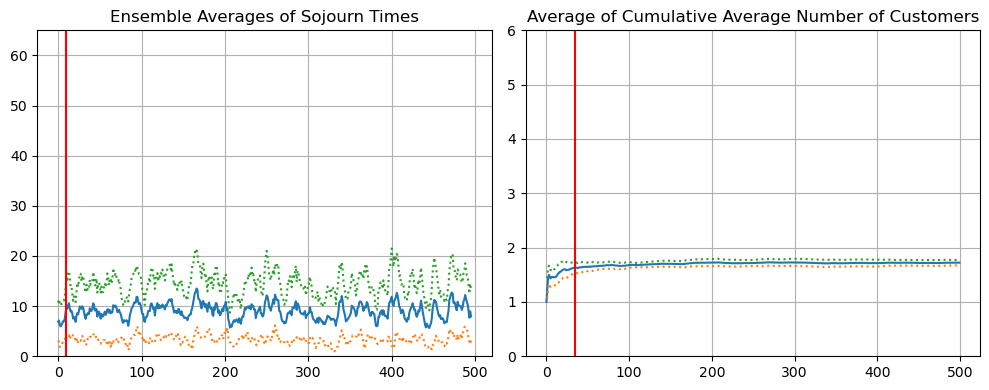

p = 0.6 and replications = 30
Warmup period: 162.63


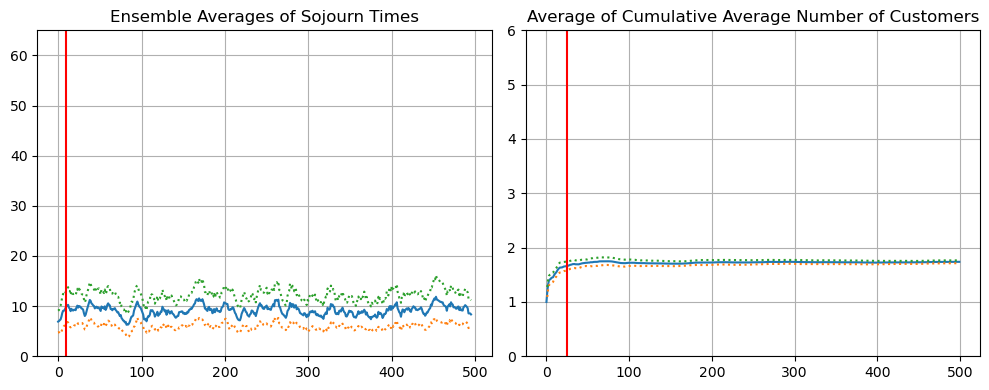

p = 0.7 and replications = 10
Warmup period: 260.20


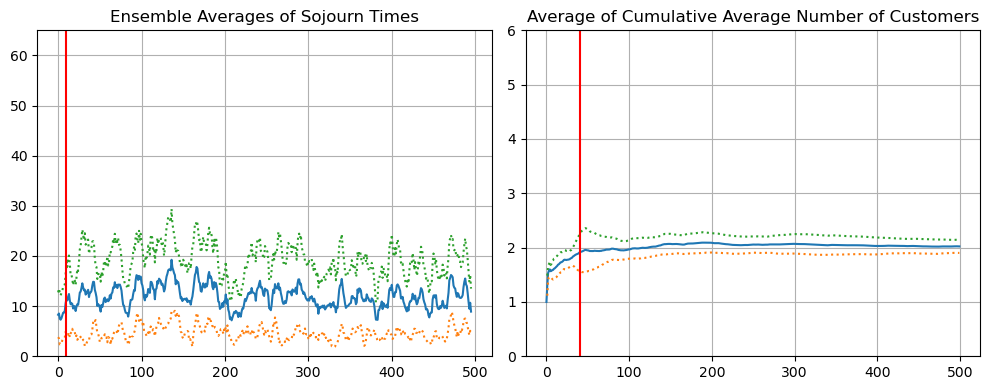

p = 0.7 and replications = 30
Warmup period: 260.20


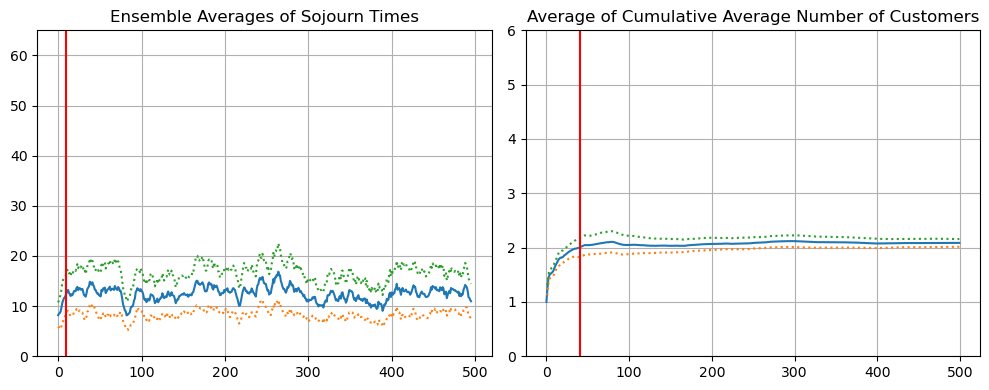

p = 0.8 and replications = 10
Warmup period: 650.50


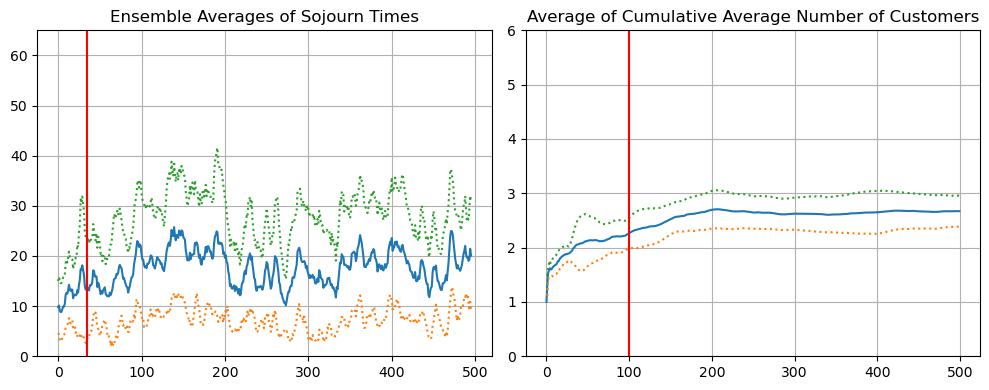

p = 0.8 and replications = 30
Warmup period: 390.30


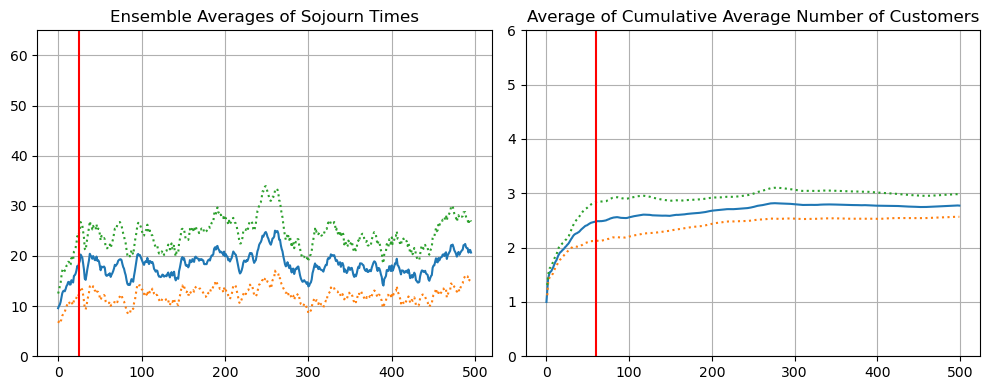

p = 0.9 and replications = 10
Warmup period: 552.93


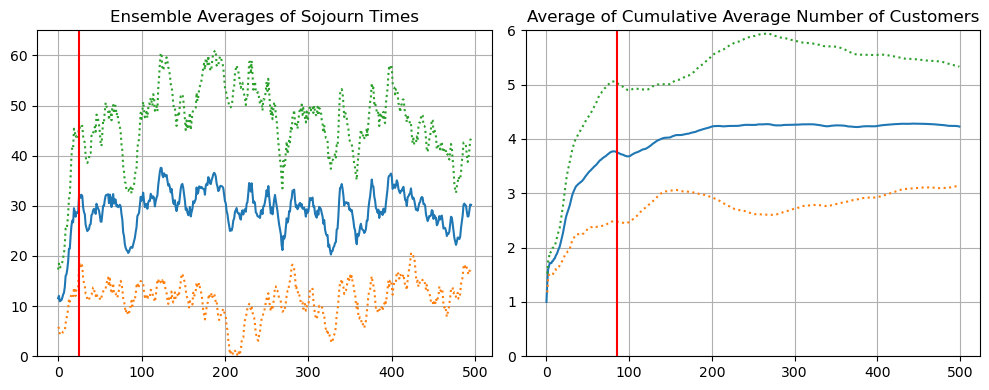

p = 0.9 and replications = 30
Warmup period: 552.93


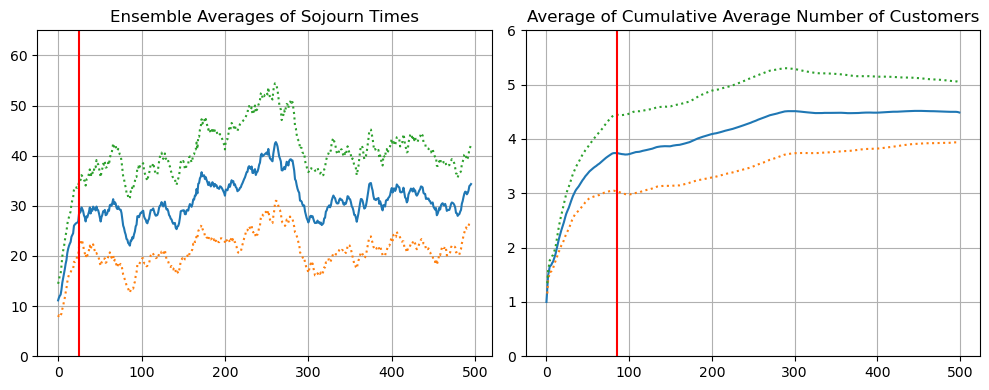

In [143]:
sojourn_ensemble_convergence_points = (10, 10, 10, 10, 35, 25, 25, 25)
cumulative_customer_average_convergence_points = (35, 25, 40, 40, 100, 60, 85, 85)
idx = 0
for p in utils:
    Ls = c * p  # average number of busy servers =>  ρ = Ls / c = λ / cµ 
    SERVICE_RATE = ARRIVAL_RATE / Ls   #  µ =  λ / Ls
    for replications in (10, 30):
        # first response
        sojourn_ensembles = np.zeros((replications, NUMBER_OF_JOBS))
        sojourn_ensemble_lower_bounds = np.zeros(NUMBER_OF_JOBS)
        sojourn_ensemble_upper_bounds = np.zeros(NUMBER_OF_JOBS)
        
        # second response
        cumulative_customer_averages = np.zeros((replications, NUMBER_OF_JOBS))
        cumulative_customer_average_lower_bounds = np.zeros(NUMBER_OF_JOBS)
        cumulative_customer_average_upper_bounds = np.zeros(NUMBER_OF_JOBS)
        
        for r in range(replications):
            RANDOM_SEED = r * 100
            random.seed(RANDOM_SEED)
            
            customers_in_system = 0
            cumulative_customer_number = 0
            
            env = simpy.Environment()
            server = simpy.Resource(env, capacity=c)
            env.process(job_generator(env, server, r))
            env.run()

        sojourn_ensemble_averages = np.mean(sojourn_ensembles, axis=0)
        average_of_cumulative_customer_averages = np.mean(cumulative_customer_averages, axis=0)
        
        for i in range(NUMBER_OF_JOBS):
            conf_int_sojourn = st.t.interval(0.95,
                                             replications - 1,
                                             loc=sojourn_ensemble_averages[i],
                                             scale=st.sem(sojourn_ensembles[:, i]))
            sojourn_ensemble_lower_bounds[i] = conf_int_sojourn[0]
            sojourn_ensemble_upper_bounds[i] = conf_int_sojourn[1]
            
            conf_int_avg_cum_jobs = st.t.interval(0.95,
                                                  replications - 1,
                                                  loc=average_of_cumulative_customer_averages[i],
                                                  scale=st.sem(cumulative_customer_averages[:, i]))
            cumulative_customer_average_lower_bounds[i] = conf_int_avg_cum_jobs[0]
            cumulative_customer_average_upper_bounds[i] = conf_int_avg_cum_jobs[1]
        
        # approximate warmup period assuming that system is steady --> ARRIVAL_RATE = DEPARTURE_RATE
        # WARMUP_PERIOD ~= (1/ DEPARTURE_RATE) * CUSTOMER NUMBER
        
        # To calculate the warmup period, we chose the largest of the two responses as the largest one encapsulates
        # the both responses in terms of the bias convergence time. We calculated the warmup periods for each output by using 
        # the above time approximation. 
        warmup_period = 1/ARRIVAL_RATE * max(sojourn_ensemble_convergence_points[idx], 
                                             cumulative_customer_average_convergence_points[idx])
        print(f"p = {p} and replications = {replications}")
        print(f"Warmup period: {warmup_period:.2f}")
        
        w = 5
        smooth_sojourn_ensemble_averages = np.convolve(sojourn_ensemble_averages, np.ones(w), 'valid') / w
        smooth_sojourn_ensemble_lower_bounds = np.convolve(sojourn_ensemble_lower_bounds, np.ones(w), 'valid') / w
        smooth_sojourn_ensemble_upper_bounds = np.convolve(sojourn_ensemble_upper_bounds, np.ones(w), 'valid') / w
        
        plot_responses(smooth_sojourn_ensemble_averages, smooth_sojourn_ensemble_lower_bounds, 
                       smooth_sojourn_ensemble_upper_bounds, average_of_cumulative_customer_averages, 
                       cumulative_customer_average_lower_bounds, cumulative_customer_average_upper_bounds,
                       sojourn_ensemble_convergence_points[idx], cumulative_customer_average_convergence_points[idx])
        
        idx += 1
        


# Second Phase

In [144]:
replications = 10
p = 0.8
Ls = c * p
NUMBER_OF_JOBS = 20
T0 = 650.50

### Empty System

In [145]:
# first response
sojourn_ensembles = np.zeros((replications, NUMBER_OF_JOBS))
sojourn_ensembles_conf_intervals = np.zeros((NUMBER_OF_JOBS, 2))

# second response
cumulative_customer_averages = np.zeros((replications, NUMBER_OF_JOBS))
cumulative_customer_averages_conf_intervals = np.zeros((NUMBER_OF_JOBS, 2))

for r in range(replications):
    RANDOM_SEED = r * 1000
    random.seed(RANDOM_SEED)

    customers_in_system = 0
    cumulative_customer_number = 0

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=c)
    env.process(job_generator(env, server, r))
    env.run()

sojourn_ensemble_averages = np.mean(sojourn_ensembles, axis=0)
average_of_cumulative_customer_averages = np.mean(cumulative_customer_averages, axis=0)    
    
for i in range(NUMBER_OF_JOBS):
    conf_int_sojourn = st.t.interval(0.95,
                                     replications - 1,
                                     loc=sojourn_ensemble_averages[i],
                                     scale=st.sem(sojourn_ensembles[:, i]))
    sojourn_ensembles_conf_intervals[i][0] = conf_int_sojourn[0]
    sojourn_ensembles_conf_intervals[i][1] = conf_int_sojourn[1]

    conf_int_avg_cum_jobs = st.t.interval(0.95,
                                          replications - 1,
                                          loc=average_of_cumulative_customer_averages[i],
                                          scale=st.sem(cumulative_customer_averages[:, i]))
    cumulative_customer_averages_conf_intervals[i][0] = conf_int_avg_cum_jobs[0]
    cumulative_customer_averages_conf_intervals[i][1] = conf_int_avg_cum_jobs[1]

print("Average values and confidence intervals after 20 jobs starting with empty system: \n")
    
print(f"Sojourn ensemble average: {sojourn_ensemble_averages[-1]}")
print(f"Confidence interval of sojourn ensemble average: {sojourn_ensembles_conf_intervals[-1]}")
print(f"Average number of jobs in the system: {average_of_cumulative_customer_averages[-1]}")
print(f"Confidence interval of average number of jobs in the system: {cumulative_customer_averages_conf_intervals[-1]}")


Average values and confidence intervals after 20 jobs starting with empty system: 

Sojourn ensemble average: 22.918694580411206
Confidence interval of sojourn ensemble average: [15.10199099 30.73539817]
Average number of jobs in the system: 2.43
Confidence interval of average number of jobs in the system: [1.79301539 3.06698461]


### 4 Jobs in the System

In [146]:
# first response
sojourn_ensembles = np.zeros((replications, NUMBER_OF_JOBS))
sojourn_ensembles_conf_intervals = np.zeros((NUMBER_OF_JOBS, 2))

# second response
cumulative_customer_averages = np.zeros((replications, NUMBER_OF_JOBS))
cumulative_customer_averages_conf_intervals = np.zeros((NUMBER_OF_JOBS, 2))

for r in range(replications):
    RANDOM_SEED = r * 1000
    random.seed(RANDOM_SEED)

    customers_in_system = 4
    cumulative_customer_number = 4

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=c)
    for i in range(4):
        env.process(arrival(f'Job {i + 1}', env, server, i, r))
    env.process(job_generator(env, server, r, 4))
    env.run()

sojourn_ensemble_averages = np.mean(sojourn_ensembles, axis=0)
average_of_cumulative_customer_averages = np.mean(cumulative_customer_averages, axis=0)    
    
for i in range(NUMBER_OF_JOBS):
    conf_int_sojourn = st.t.interval(0.95,
                                     replications - 1,
                                     loc=sojourn_ensemble_averages[i],
                                     scale=st.sem(sojourn_ensembles[:, i]))
    sojourn_ensembles_conf_intervals[i][0] = conf_int_sojourn[0]
    sojourn_ensembles_conf_intervals[i][1] = conf_int_sojourn[1]

    conf_int_avg_cum_jobs = st.t.interval(0.95,
                                          replications - 1,
                                          loc=average_of_cumulative_customer_averages[i],
                                          scale=st.sem(cumulative_customer_averages[:, i]))
    cumulative_customer_averages_conf_intervals[i][0] = conf_int_avg_cum_jobs[0]
    cumulative_customer_averages_conf_intervals[i][1] = conf_int_avg_cum_jobs[1]

print("Average values and confidence intervals after 20 jobs starting with 4 jobs in the system: \n")    
    
print(f"Sojourn ensemble average: {sojourn_ensemble_averages[-1]}")
print(f"Confidence interval of sojourn ensemble average: {sojourn_ensembles_conf_intervals[-1]}")
print(f"Average number of jobs in the system: {average_of_cumulative_customer_averages[-1]}")
print(f"Confidence interval of average number of jobs in the system: {cumulative_customer_averages_conf_intervals[-1]}")

Average values and confidence intervals after 20 jobs starting with 4 jobs in the system: 

Sojourn ensemble average: 22.919617867486703
Confidence interval of sojourn ensemble average: [10.54146291 35.29777283]
Average number of jobs in the system: 3.335
Confidence interval of average number of jobs in the system: [2.46963659 4.20036341]


### Empty System with Warmup

In [147]:
NUMBER_OF_JOBS = 200

# first response
sojourn_ensembles = np.zeros((replications, NUMBER_OF_JOBS))
sojourn_ensembles_conf_intervals = np.zeros((20, 2))

# second response
cumulative_customer_averages = np.zeros((replications, NUMBER_OF_JOBS))
cumulative_customer_averages_conf_intervals = np.zeros((20, 2))

# collect data after warmup period
start_indices = np.zeros(replications)
sojourn_ensembles_warmup = np.zeros((replications, 20))
cumulative_customer_averages_warmup = np.zeros((replications, 20))

for r in range(replications):
    RANDOM_SEED = r * 10000
    random.seed(RANDOM_SEED)

    customers_in_system = 0
    cumulative_customer_number = 0

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=c)
    env.process(job_generator(env, server, r))
    env.run(until = T0)
    start_indices[r] = customers_in_system + 1
    env.run()
    
for r in range(replications):
    sojourn_ensembles_warmup[r] = sojourn_ensembles[r, int(start_indices[r]):int(start_indices[r]+20)]
    cumulative_customer_averages_warmup[r] = cumulative_customer_averages[r, int(start_indices[r]):int(start_indices[r]+20)]

sojourn_ensemble_averages = np.mean(sojourn_ensembles_warmup, axis=0)
average_of_cumulative_customer_averages = np.mean(cumulative_customer_averages_warmup, axis=0)    
    
for i in range(20):
    conf_int_sojourn = st.t.interval(0.95,
                                     replications - 1,
                                     loc=sojourn_ensemble_averages[i],
                                     scale=st.sem(sojourn_ensembles[:, i]))
    sojourn_ensembles_conf_intervals[i][0] = conf_int_sojourn[0]
    sojourn_ensembles_conf_intervals[i][1] = conf_int_sojourn[1]

    conf_int_avg_cum_jobs = st.t.interval(0.95,
                                          replications - 1,
                                          loc=average_of_cumulative_customer_averages[i],
                                          scale=st.sem(cumulative_customer_averages[:, i]))
    cumulative_customer_averages_conf_intervals[i][0] = conf_int_avg_cum_jobs[0]
    cumulative_customer_averages_conf_intervals[i][1] = conf_int_avg_cum_jobs[1]

print("Average values and confidence intervals after 20 jobs with a warmup period before: \n")    
    
print(f"Sojourn ensemble average: {sojourn_ensemble_averages[-1]}")
print(f"Confidence interval of sojourn ensemble average: {sojourn_ensembles_conf_intervals[-1]}")
print(f"Average number of jobs in the system: {average_of_cumulative_customer_averages[-1]}")
print(f"Confidence interval of average number of jobs in the system: {cumulative_customer_averages_conf_intervals[-1]}")

Average values and confidence intervals after 20 jobs with a warmup period before: 

Sojourn ensemble average: 21.761688055134357
Confidence interval of sojourn ensemble average: [13.30316632 30.22020979]
Average number of jobs in the system: 3.4965609285050503
Confidence interval of average number of jobs in the system: [2.85114098 4.14198088]
